In [1]:
import numpy as np
import torch
from torch.autograd.functional import jacobian
from torch.autograd.functional import hessian
import matplotlib.pyplot as plt
from track import *
tkwargs = {
    "dtype" : torch.double
}
import time
np.set_printoptions(precision= 16, suppress=False)
torch.set_printoptions(precision= 16, sci_mode=True)
torch.__version__, np.__version__

('1.10.2', '1.22.2')

In [2]:
c_light = 2.99792458e8 #speed of light in m/s
m_e = 0.510998950e6 #electron mass in eV

In [3]:
def normalize(x, bounds):
    return (x-bounds[0]) / (bounds[1]-bounds[0])
def inv_normalize(x, bounds):
    return (bounds[1]-bounds[0])*x + bounds[0]

# Optimization examples

## No regularization

In [4]:
s = 0.0 #initial s
p0c = 4.0E+07 #Reference particle momentum in eV
mc2 = 1*m_e # electron mass in eV
ts = torch.tensor(s, **tkwargs)
tp0c = torch.tensor(p0c, **tkwargs)
tmc2 = torch.tensor(mc2, **tkwargs)

# Initial beam distribution
sample_size = 1000
mean = torch.zeros(6, **tkwargs)
cov = torch.diag(torch.tensor([1e-6, 2e-6, 1e-6, 2e-6, 1e-6, 2e-6],**tkwargs))
dist = torch.distributions.multivariate_normal.MultivariateNormal(mean, cov)
sample = dist.sample(torch.Size([sample_size]))
p_in = Particle(*sample.T, ts, tp0c, tmc2)

# Lattice fixed parameters
L_d = 1.00 # Drift length
L_q = 0.1 # Quad length 
drift = Drift(torch.tensor(L_d, **tkwargs))

In [5]:
NUM_STEPS = 1

# Objective function (O.F.)
def beamsize(k1s):
    """Returns std(sqrt(x^2+y^2)) after lattice composed by len(k1s)+1 drifts with
    len(k1s) quadrupoles in between.
    """
    lattice = [drift]
    for k1 in k1s:
        lattice.append( Quadrupole(torch.tensor(L_q, **tkwargs), k1, NUM_STEPS) )
        lattice.append( drift )
    p_out = track_a_lattice(p_in, lattice)[-1]
    return torch.std(torch.sqrt(p_out.x**2+p_out.y**2))

# Model to optimize using torch.nn.Module
class BeamSizeModel(torch.nn.Module):
    """Beam size torch module."""
    def __init__(self, k1s):
        super().__init__()
        self.register_parameter('k1s',torch.nn.Parameter(k1s))
    def forward(self):
        return beamsize(self.k1s)

In [6]:
def train_model(model, training_iter):
    history_param = [None] * training_iter
    history_loss = [None] * training_iter
    # print the trainable parameters
    for param in model.named_parameters():
        print(f'{param[0]} : {param[1]}')
    
    # Use the adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

    for i in range(training_iter):
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Calc loss and backprop gradients
        loss = model()  # loss is just O.F.
        loss.backward()
        if i%10==0: #print each 10 steps
            print('Iter %d/%d - Loss: %.5f '% (
                i + 1, training_iter, loss.item()
            ))
        for param in model.parameters():
            history_param[i] = param.data.detach().numpy().copy()
        history_loss[i] = loss.detach().numpy().copy()
        optimizer.step()
        

    return np.asarray(history_param), np.asarray(history_loss)

In [7]:
%%time
# Initial k1s
k1s = torch.zeros(10, **tkwargs)

# Optimization
model = BeamSizeModel(k1s)
params, loss = train_model(model, 500)

k1s : Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=torch.float64,
       requires_grad=True)
Iter 1/500 - Loss: 0.01099 
Iter 11/500 - Loss: 0.01115 
Iter 21/500 - Loss: 0.01105 
Iter 31/500 - Loss: 0.01099 
Iter 41/500 - Loss: 0.01095 
Iter 51/500 - Loss: 0.01075 
Iter 61/500 - Loss: 0.00950 
Iter 71/500 - Loss: 0.00473 
Iter 81/500 - Loss: 0.00417 
Iter 91/500 - Loss: 0.00249 
Iter 101/500 - Loss: 0.00143 
Iter 111/500 - Loss: 0.00077 
Iter 121/500 - Loss: 0.00052 
Iter 131/500 - Loss: 0.00050 
Iter 141/500 - Loss: 0.00043 
Iter 151/500 - Loss: 0.00040 
Iter 161/500 - Loss: 0.00044 
Iter 171/500 - Loss: 0.00040 
Iter 181/500 - Loss: 0.00040 
Iter 191/500 - Loss: 0.00046 
Iter 201/500 - Loss: 0.00041 
Iter 211/500 - Loss: 0.00039 
Iter 221/500 - Loss: 0.00043 
Iter 231/500 - Loss: 0.00041 
Iter 241/500 - Loss: 0.00038 
Iter 251/500 - Loss: 0.00043 
Iter 261/500 - Loss: 0.00041 
Iter 271/500 - Loss: 0.00038 
Iter 281/500 - Loss: 0.00043 
Iter 291/500 - L

Text(0.5, 0, 'n_iter')

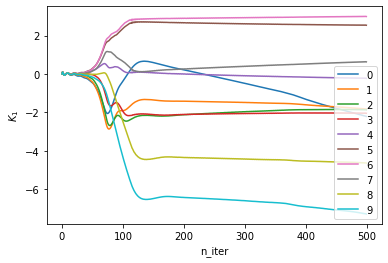

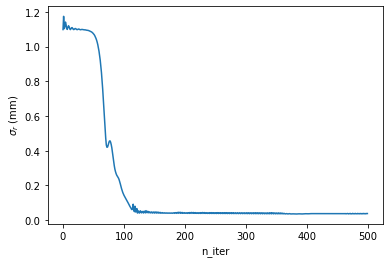

In [8]:
# Plot O.F. and parameters as function of iteration number
for i in range(len(k1s)):
    plt.plot(np.arange(len(params[:,0])), params[:,i], label=str(i))
plt.legend()
plt.ylabel(r'$K_1$')
plt.xlabel('n_iter')
plt.figure()
plt.plot(np.arange(len(loss)), loss*100)
plt.ylabel(r'$\sigma_r$ (mm)')
plt.xlabel('n_iter')
#params, loss

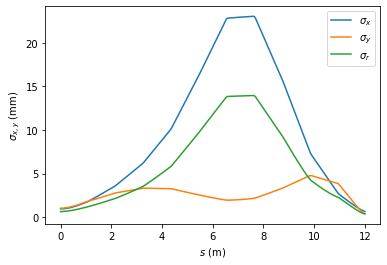

In [9]:
# plot beamsize for final config
lattice = [drift]
k1s = torch.tensor(params[-1], **tkwargs)
for k1 in k1s:
    lattice.append( Quadrupole(torch.tensor(L_q, **tkwargs), k1, NUM_STEPS) )
    lattice.append( drift )
n=10
stubbed_lattice = stub_lattice(lattice, n)
all_p = track_a_lattice(p_in, stubbed_lattice)
stdx, stdy, stdr, s = [torch.std(par.x) for par in all_p], [torch.std(par.y) for par in all_p], [torch.std(torch.sqrt(par.x**2+par.y**2)) for par in all_p], [par.s for par in all_p]
plt.plot(s, np.array(stdx)*1000, label=r'$\sigma_x$')
plt.plot(s, np.array(stdy)*1000, label=r'$\sigma_y$')
plt.plot(s, np.array(stdr)*1000, label=r'$\sigma_r$')
plt.xlabel(r'$s$ (m)')
plt.ylabel(r'$\sigma_{x,y}$ (mm)')
plt.legend()

## Regularization

In [16]:
# bounds
beamsize_bounds = torch.tensor([0.0, 11.2e-3], **tkwargs)
k_bounds = torch.tensor([-10, 10], **tkwargs)

In [17]:
NUM_STEPS = 1

# Objective function (O.F.)
def beamsize(k1s):
    """Returns std(sqrt(x^2+y^2)) after lattice composed by len(k1s)+1 drifts with
    len(k1s) quadrupoles in between.
    """
    lattice = [drift]
    for k1 in k1s:
        lattice.append( Quadrupole(torch.tensor(L_q, **tkwargs), k1, NUM_STEPS) )
        lattice.append( drift )
    p_out = track_a_lattice(p_in, lattice)[-1]
    return torch.std(torch.sqrt(p_out.x**2+p_out.y**2))

# Model to optimize using torch.nn.Module
class BeamSizeModel(torch.nn.Module):
    """Beam size torch module."""
    def __init__(self, k1s):
        super().__init__()
        self.register_parameter('k1s',torch.nn.Parameter(k1s))
    def forward(self):
        regularizer = torch.sqrt(torch.sum(normalize(self.k1s, k_bounds)**2))
        return normalize(beamsize(self.k1s), beamsize_bounds) + regularizer  # O.F.

In [18]:
def train_model(model, training_iter):
    history_param = [None] * training_iter
    history_loss = [None] * training_iter
    # print the trainable parameters
    for param in model.named_parameters():
        print(f'{param[0]} : {param[1]}')
    
    # Use the adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

    for i in range(training_iter):
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Calc loss and backprop gradients
        loss = model()  # loss is just O.F.
        loss.backward()
        if i%10==0: #print each 10 steps
            print('Iter %d/%d - Loss: %.5f '% (
                i + 1, training_iter, loss.item()
            ))
        for param in model.parameters():
            history_param[i] = param.data.detach().numpy().copy()
        history_loss[i] = loss.detach().numpy().copy()
        optimizer.step()
        

    return np.asarray(history_param), np.asarray(history_loss)

In [19]:
%%time
# Initial k1s
k1s = torch.zeros(10, **tkwargs)

# Optimization
model = BeamSizeModel(k1s)
params, loss = train_model(model, 500)

k1s : Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=torch.float64,
       requires_grad=True)
Iter 1/500 - Loss: 2.56239 
Iter 11/500 - Loss: 2.57432 
Iter 21/500 - Loss: 2.54881 
Iter 31/500 - Loss: 2.49919 
Iter 41/500 - Loss: 2.35065 
Iter 51/500 - Loss: 1.96118 
Iter 61/500 - Loss: 1.52883 
Iter 71/500 - Loss: 1.47073 
Iter 81/500 - Loss: 1.47069 
Iter 91/500 - Loss: 1.45455 
Iter 101/500 - Loss: 1.43399 
Iter 111/500 - Loss: 1.44762 
Iter 121/500 - Loss: 1.42362 
Iter 131/500 - Loss: 1.41322 
Iter 141/500 - Loss: 1.43257 
Iter 151/500 - Loss: 1.41780 
Iter 161/500 - Loss: 1.39698 
Iter 171/500 - Loss: 1.41912 
Iter 181/500 - Loss: 1.40901 
Iter 191/500 - Loss: 1.38613 
Iter 201/500 - Loss: 1.41181 
Iter 211/500 - Loss: 1.40485 
Iter 221/500 - Loss: 1.37849 
Iter 231/500 - Loss: 1.40578 
Iter 241/500 - Loss: 1.39860 
Iter 251/500 - Loss: 1.37286 
Iter 261/500 - Loss: 1.40265 
Iter 271/500 - Loss: 1.39083 
Iter 281/500 - Loss: 1.36857 
Iter 291/500 - L

Text(0.5, 0, 'n_iter')

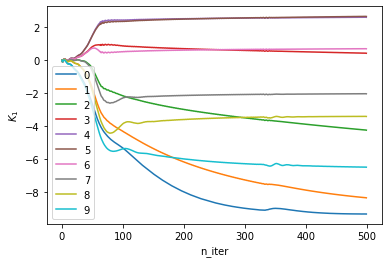

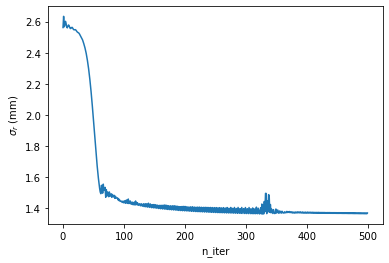

In [20]:
# Plot O.F. and parameters as function of iteration number
for i in range(len(k1s)):
    plt.plot(np.arange(len(params[:,0])), params[:,i], label=str(i))
plt.legend()
plt.ylabel(r'$K_1$')
plt.xlabel('n_iter')
plt.figure()
plt.plot(np.arange(len(loss)), loss)
plt.ylabel(r'$\sigma_r$ (mm)')
plt.xlabel('n_iter')
#params, loss

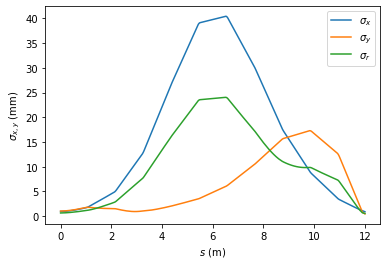

In [21]:
# plot beamsize for final config
lattice = [drift]
k1s = torch.tensor(params[-1], **tkwargs)
for k1 in k1s:
    lattice.append( Quadrupole(torch.tensor(L_q, **tkwargs), k1, NUM_STEPS) )
    lattice.append( drift )
n=10
stubbed_lattice = stub_lattice(lattice, n)
all_p = track_a_lattice(p_in, stubbed_lattice)
stdx, stdy, stdr, s = [torch.std(par.x) for par in all_p], [torch.std(par.y) for par in all_p], [torch.std(torch.sqrt(par.x**2+par.y**2)) for par in all_p], [par.s for par in all_p]
plt.plot(s, np.array(stdx)*1000, label=r'$\sigma_x$')
plt.plot(s, np.array(stdy)*1000, label=r'$\sigma_y$')
plt.plot(s, np.array(stdr)*1000, label=r'$\sigma_r$')
plt.xlabel(r'$s$ (m)')
plt.ylabel(r'$\sigma_{x,y}$ (mm)')
plt.legend()